In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pvlib as pv
import CoolProp.CoolProp as CP
import warnings
from scipy import interpolate
from simulation_functions import corr_exp_solar, Irradiance_2,State
from bokeh.plotting.figure import Figure
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Dark2_5 as palette
# itertools handles the cycling
import itertools  

In [76]:
class Storage:
    
    def __init__(self,Storage_param):
        
        '''
        Storage's constructor function
        
        Parameters:
        ----------
            -Storage_param: Dictionary that contains the storage´s parameters
             example:
             storage_param={'T_max':T_max,     #Max temperature of the start temperature profile, °C
                            'T_min':T_min,     #Min temperature of the start temperature profile, °C
                            'n_nodes':n_nodes, #Number of nodes in the storage
                            'P':P,             # Tank´s pressure, bar
                            'D':D,             #Tank's diameter, m
                            'H':H,             #Tank's height, m
                            'e_storage':e_storage,       #Storage´s tank wall thickness,m
                            'k_storage':k_storage,       #Storage´s tank wall thermal conductivity, W/mK
                            'e_insulation':e_insulation, #Insulation´s thickness, m
                            'k_insulation':k_insulation, #Insulation´s thermal conductivity, W/mK
                            'h_out':h_out, #Storage´s outlet height, m
                            'h_in':h_in}   #Storage´s inlet height, m
            
        
        '''
        self.n_nodes=Storage_param['n_nodes'] #Number of nodes in the storage
        self.T_max=Storage_param['T_max']     #Max temperature of the start temperature profile, °C
        self.T_min=Storage_param['T_min']     #Min temperature of the start temperature profile, °C
        
        self.nodes_Temperature=np.linspace(self.T_max,self.T_min,self.n_nodes) #Start temperature profile

        self.h_nodes=Storage_param['H']/self.n_nodes #Lenght of each node, m
        self.P=Storage_param['P']*100000 # Tank´s pressure, Pa
        self.D=Storage_param['D'] #Diamameter of the tank, m
        self.H=Storage_param['H'] #Height of the tank, m
        self.A_circ=np.pi*(self.D/2)**2 #Tank's transversal area, m^2
        self.A_cil_ext=np.pi*self.D*self.h_nodes #Cilinder area of each node, m^2
        
        self.k_storage=Storage_param['k_storage'] #Storage´s thermal conductivity, W/mK
        self.e_storage=Storage_param['e_storage'] #Storage´s thickness, m
        self.k_insulation=Storage_param['k_insulation'] #Insulation´s thermal conductivity, W/mK
        self.e_insulation=Storage_param['e_insulation'] #Insulation´s thickness, m
        
        self.nodes_height=np.linspace(0,self.H,self.n_nodes+1) #Height of each node, m
        
        self.h_out=Storage_param['h_out'] #Storage´s outlet height, m
        self.h_in=Storage_param['h_in'] #Storage´s inlet height, m
   
        
    def R_k_cil_external(self,k,D_ext,D_int):
        
        '''
        Method that calculates the conductive thermal resistance of a cylindrical shell
        
        Parameters:
        ----------- 
            -k    : Thermal conductivity of the cylindrical shell material, W/(m*K)
            -D_ext: External diameter of the cylindrical shell, m
            -D_int: Internal diameter of the cylindrical shell, m
            
        Outputs:
        -----------
            -R_k : Conductive thermal resistance ot the cylindrical shell, K/W
            
        '''
        L=self.h_nodes # Height of the cylindrical shell, m
        
        R_k=np.log(D_ext/D_int)/(2*np.pi*L*k) #Conductive thermal resistance ot the cylindrical shell, K/W
        return R_k
    
    def UA_top_bottom(self,T_inf,T_f,g=9.8):
        
        '''
        Function that calculates the UA between the fluid inside the tank and the environment at the bottom and the upper tank's faces.
        Assuming that the internal face of the storage has the same temperature that the fluid. 
        
        Parameters:
        -----------
            T_inf: Environmental temperature, °C
            T_f : Fluid's temperature, °C
            
        Outputs:
        -----------
            UA: UA between the fluid inside the tank and the environment, W/K
        '''
        
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0
        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air') 
            B_air_ext=1/(T_p+273) 
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 0<Ra<10**9:#10**4<Ra<10**9:
                h=1.32*(np.abs(T_s-T_inf)/D)**0.25
            elif Ra>=10**9:
                h=1.43*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
                
            if self.k_storage!=0: 
                R_k_storage=self.e_storage/(self.k_storage*self.A_circ)
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.e_insulation/(self.k_insulation*self.A_circ)    
            else:
                R_k_insulation=0
                
            UA=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
                  
            Q_f_inf=(T_f-T_inf)*UA
            Q_s_inf=(T_s-T_inf)*self.A_circ*h
            
            err=np.abs(Q_f_inf-Q_s_inf)/Q_s_inf*100
            
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_circ*h)
                it+=1
                
        return UA
        
        
        
    def UA_external_surface(self,T_inf,T_f,g=9.8):
        '''
        Function that calculates the UA between the fluid inside the tank and the environment at the external cilinder's face.
        Assuming that the internal face of the storage has the same temperature that the fluid. 
        
        Parameters:
        -----------
            T_inf: Environmental temperature, °C
            T_f : Fluid's temperature, °C
            
        Outputs:
        -----------
            UA_ext: UA between the fluid inside the tank and the environment, W/K
        '''
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0

        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air')
            B_air_ext=1/(T_p+273)   
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 10**4<Ra<10**9:#10**4<Ra<10**9:
                h=1.42*(np.abs(T_s-T_inf)/L)**0.25
            elif Ra>=10**9:
                h=0.95*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
               
            if self.k_storage!=0: 
                R_k_storage=self.R_k_cil_external(self.k_storage,D_ext=D,D_int=D-self.e_storage)    
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.R_k_cil_external(self.k_insulation,D_ext=D+self.e_insulation,D_int=D)    
            else:
                R_k_insulation=0
                    
            UA_ext=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
            
            Q_f_inf=(T_f-T_inf)*UA_ext
            Q_s_inf=(T_s-T_inf)*self.A_cil_ext*h
            
            err=np.abs((Q_f_inf-Q_s_inf)/Q_s_inf*100)
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_cil_ext*h)
                it+=1
    
    
        return UA_ext
    
    def Conduction(self,T_hot,T_cold):
        '''
        Function that calculates the heat transferred from one node to another by conduction.
        
        Parameters:
        ----------
            T_hot: Temperature of the hot node, °C
            T_cold: Temperature of the cold node, °C
        
        Outputs:
        --------
            Q_cond: heat transferred from one node to another by conduction, W
        '''
        
        k_nodes=CP.PropsSI('L','P',self.P,'T',np.linspace(273+np.max(self.nodes_Temperature),273+np.min(self.nodes_Temperature),n_nodes),'water')
        k_nodes=np.mean(k_nodes)
        
        Q_cond=k_nodes*self.A_circ*(T_hot-T_cold)/self.h_nodes
        
        return Q_cond
    
    def Mass_balance(self,m_in,m_out):
        '''
        Function that calculates one of the inlets mass flow to enforce the mass conservation inside the tank. This function assumes that 
        there are the exact same number of inlets and outlets. 
        
        Parameters:
        -----------
        m_in: Array or list that contains the values of the inlets mass flow.
        m_out: Array or list that contains the values of the outlets mass flow.
        '''
        
        M_in=np.sum(m_out)-np.sum(m_in)
        m_in=np.insert(m_in,len(m_in),M_in)
        return(m_in)
            
    
    
    def Mass_energy_balance(self,dt,M_in=None,T_in=None,M_out=None,T_inf=None):
        
        '''
        Method that updates the temperature of the nodes by considering an
        '''
        
        rho_nodes=CP.PropsSI('D','P',self.P,'T',                              # Array that contains
                             np.linspace(273+np.max(self.nodes_Temperature),  # the value of density 
                             273+np.min(self.nodes_Temperature),self.n_nodes),     # on each node
                             'water')                                         #
        rho_nodes=np.mean(rho_nodes) # Mean value of density, kg/m^{3}
        
        V=self.A_circ*self.h_nodes  #Volume of each node, m^{3}
        
        cp_nodes=CP.PropsSI('C','P',self.P,'T',                               # Array that contains 
                            np.linspace(273+np.max(self.nodes_Temperature),   # the value of Cp on
                            273+np.min(self.nodes_Temperature),n_nodes),      # each node
                            'water')                                          #
        cp_nodes=np.mean(cp_nodes) # Mean value of Cp, J/(kg*K)
        
        #self.M_vector(T_in=T_in) 
        self.M_vector_fix_in()
        in_out=np.concatenate((self.node_in, self.node_out), axis=1)
        self.in_out=in_out
        M_in=self.Mass_balance(M_in,M_out)
    
        for i in range(len(in_out)):
            n=0
            in_out_index=np.linspace(int(in_out[i][0]),int(in_out[i][-1]),int(np.abs((in_out[i][0]-in_out[i][-1]))+1))
            old_nodes_Temperature=self.nodes_Temperature
            for j in in_out_index:
                j=int(j)
                
                if n==0:
                    T_inlet=T_in[i]
                    
                    h_inlet=CP.PropsSI('H','P',self.P,'T',T_inlet+273,'water')
                    h_j=CP.PropsSI('H','P',self.P,'T',self.nodes_Temperature[j]+273,'water')
                    m_i=V*CP.PropsSI('D','P',self.P,'T',self.nodes_Temperature[j]+273,'water')
                    h_j=(M_in[i]*dt*h_inlet+m_i*h_j)/(M_in[i]*dt+m_i)
                    self.nodes_Temperature[j]=CP.PropsSI('T','P',self.P,'H',h_j,'water')-273
                    
                    
            
                    #T_out=(M_in[i]*dt*T_inlet+V*rho_nodes*self.nodes_Temperature[j])/(M_in[i]*dt+V*rho_nodes)
                    #self.nodes_Temperature[j]=self.nodes_Temperature[j]+dt*M_in[i]*cp_nodes*(T_inlet-T_out)/(V*rho_nodes*cp_nodes)

                else:
 
                    #T_inlet=T_out#old_nodes_Temperature[int(in_out_index[j-1])]
                    #h_inlet=CP.PropsSI('H','P',self.P,'T',T_inlet+273,'water')
                    
                    h_inlet=h_j
                    
                    h_j=CP.PropsSI('H','P',self.P,'T',old_nodes_Temperature[j]+273,'water')
                    m_i=V*CP.PropsSI('D','P',self.P,'T',old_nodes_Temperature[j]+273,'water')
                    h_j=(M_in[i]*dt*h_inlet+m_i*h_j)/(M_in[i]*dt+m_i)
                    self.nodes_Temperature[j]=CP.PropsSI('T','P',self.P,'H',h_j,'water')-273
                    
                    
                    #T_out=(M_in[i]*dt*T_inlet+V*rho_nodes*self.nodes_Temperature[j])/(M_in[i]*dt+V*rho_nodes)
                    #self.nodes_Temperature[j]=self.nodes_Temperature[j]+dt*M_in[i]*cp_nodes*(T_inlet-T_out)/(V*rho_nodes*cp_nodes)
                n+=1

        self.Energy_balance_K_H(dt=dt,T_inf=T_inf)
        self.Unstable_check()

        
    
    def M_vector_1_node(self,T_in):
        '''
        Funtion that calculates in which node there will be located the inlets and outlets of the tank.
        To the inlets, the node will be determinated by the temperature, defining that the mass flow will enter
        in the node whose temperature is nearest to the temperature of the mass flow. 
        For the outlets, the node will be determined by the height of the outlets define at the moment of definig
        the storage. 
        
        
        Parameters:
        -----------
            T_in: Temperature of the inlets flux, °C
            
        Outputs:
        -----------
            self.M_in : Matrix with rows equal to the number of nodes and columns equal to the number of inlets.
                        The location of inlets are marked with a number 1.
            self.M_out: Matrix with rows equal to the number of nodes and columns equal to the number of outlets.
                        The location of inlets are marked with a number -1.
        '''
        
        m_in=np.ones([self.n_nodes,len(T_in)])
        m_out=np.ones([self.n_nodes,len(self.h_out)])*-1
            
        self.M_in,self.M_out=m_in,np.flip(m_out)
        
    def M_vector(self,T_in):
        '''
        Funtion that calculates in which node there will be located the inlets and outlets of the tank.
        To the inlets, the node will be determinated by the temperature, defining that the mass flow will enter
        in the node whose temperature is nearest to the temperature of the mass flow. 
        For the outlets, the node will be determined by the height of the outlets define at the moment of definig
        the storage. 
        
        Parameters:
        -----------
            T_in: Temperature of the inlets flux, °C
            
        Outputs:
        -----------
            self.M_in : Matrix with rows equal to the number of nodes and columns equal to the number of inlets.
                        The location of inlets are marked with a number 1.
            self.M_out: Matrix with rows equal to the number of nodes and columns equal to the number of outlets.
                        The location of inlets are marked with a number -1.
        '''
        
        m_in=np.zeros([self.n_nodes,len(T_in)])
        m_out=np.zeros([self.n_nodes,len(self.h_out)])
        
        node_in=np.zeros([len(T_in),1])
        node_out=np.zeros([len(self.h_out),1])
        
        for i in range(len(T_in)):
            for j in range(self.n_nodes-1):
                if self.nodes_Temperature[j]>=T_in[i]>self.nodes_Temperature[j+1]:
                    m_in[j][i]=1
                    node_in[i][0]=j
                elif self.nodes_Temperature[0]<T_in[i]:
                    m_in[0][i]=1
                    node_in[i][0]=0
                elif self.nodes_Temperature[-1]>=T_in[i]:
                    m_in[-1][i]=1
                    node_in[i][0]=self.n_nodes-1
                    
        for i in range(len(self.h_out)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_out[i]<self.nodes_height[j+1]:
                    m_out[j][i]=-1
                    node_out[i][0]=self.n_nodes-j-1
                    
        
        node_out=np.flip(node_out)
        
        self.node_out,self.node_in=node_out,node_in
        self.M_in,self.M_out=m_in,np.flip(m_out)
    
    def M_vector_fix_in(self):
        '''
        Funtion that calculates in which node there will be located the inlets and outlets of the tank.
        To the inlets, the node will be determinated by the temperature, defining that the mass flow will enter
        in the node whose temperature is nearest to the temperature of the mass flow. 
        For the outlets, the node will be determined by the height of the outlets define at the moment of definig
        the storage. 
        
        Parameters:
        -----------
            T_in: Temperature of the inlets flux, °C
            
        Outputs:
        -----------
            self.M_in : Matrix with rows equal to the number of nodes and columns equal to the number of inlets.
                        The location of inlets are marked with a number 1.
            self.M_out: Matrix with rows equal to the number of nodes and columns equal to the number of outlets.
                        The location of inlets are marked with a number -1.
        '''
        
        m_in=np.zeros([self.n_nodes,len(self.h_in)])
        m_out=np.zeros([self.n_nodes,len(self.h_out)])
        
        node_in=np.zeros([len(self.h_in),1])
        node_out=np.zeros([len(self.h_out),1])
        
        for i in range(len(self.h_in)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_in[i]<self.nodes_height[j+1]:
                    m_in[j][i]=1
                    node_in[i][0]=self.n_nodes-j-1
                    
        for i in range(len(self.h_out)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_out[i]<self.nodes_height[j+1]:
                    m_out[j][i]=-1
                    node_out[i][0]=self.n_nodes-j-1
                    
        node_in=np.flip(node_in)
        node_out=np.flip(node_out)
        
        self.node_out,self.node_in=node_out,node_in
        self.M_in,self.M_out=np.flip(m_in),np.flip(m_out)
    
    def Energy_balance_1_node(self,dt,T_inf,m_in=None,T_in=None,m_out=None):
        '''
        Function that calculates and updates the temperature of each node by doing an energy balance.
        
        Parameters:
        -----------
        dt   : Time step of the simulation, s.
        T_inf: Ambient temperature, °C
        
        Outputs:
        ---------
        nodes.Temperature: Numpy array of shape (n_nodes,) that contains the resulting temperature of each node
        
        '''  
        self.M_vector_1_node(T_in=T_in) 
        m_in=self.Mass_balance(m_in,m_out)
        cp_in=CP.PropsSI('C','P',self.P,'T',273+T_in,'water')
        q_in=m_in*np.array(T_in)*cp_in
        Q_in=np.matmul(self.M_in,q_in)
        
        T_out=self.nodes_Temperature[0]

        cp_out=CP.PropsSI('C','P',self.P,'T',273+T_out,'water')
        m_out=np.reshape(np.array(m_out),(len(m_out),))
        q_out=m_out*np.array(T_out)*cp_out
        Q_out=np.matmul(self.M_out,q_out)

        cp_nodes=CP.PropsSI('C','P',self.P,'T',                               # Array that contains 
                            np.linspace(273+np.max(self.nodes_Temperature),   # the value of Cp on
                            273+np.min(self.nodes_Temperature),self.n_nodes),      # each node
                            'water')                                          #
        cp_nodes=np.mean(cp_nodes) # Mean value of Cp, J/(kg*K)
        
        rho_nodes=CP.PropsSI('D','P',self.P,'T',                              # Array that contains
                             np.linspace(273+np.max(self.nodes_Temperature),  # the value of density 
                             273+np.min(self.nodes_Temperature),self.n_nodes),     # on each node
                             'water')                                         #
        rho_nodes=np.mean(rho_nodes) # Mean value of density, kg/m^{3}
        
        V=self.A_circ*self.h_nodes  #Volume of each node, m^{3}
         
        new_nodes_Temperature=np.zeros(n_nodes) #Empty array to fulfill with the new temperature of the nodes
                
        Q_loss_top=(-self.UA_top_bottom(T_inf,self.nodes_Temperature[0]) # Heat transferred from the storage´s inside
                    *(self.nodes_Temperature[0]-T_inf))                  # to the environment by the top surface

        Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[0]) # Heat transferred from the storage´s inside
                *(self.nodes_Temperature[0]-T_inf))                        # to the environment by the cylindrical surface

        Q_loss_bottom=(self.UA_top_bottom(T_inf,self.nodes_Temperature[0]) # Heat transferred between the node at the bottom 
                       *(self.nodes_Temperature[0]-T_inf))                 # of the storage and the enviroment

        Q_m_in=Q_in[0]
        Q_m_out=Q_out[0]
        new_nodes_Temperature[0]=self.nodes_Temperature[0]+(Q_loss_external_surface+Q_loss_bottom+Q_m_in+Q_m_out)*dt/((V*rho_nodes)*cp_nodes) # New temperature of the node i
                
        self.nodes_Temperature=new_nodes_Temperature # Update of the nodes temperature
        
        return self.nodes_Temperature
    
    def Energy_balance_K_H(self,dt,T_inf):
        '''
        Function that calculates and updates the temperature of each node by doing an energy balance.
        
        Parameters:
        -----------
        dt   : Time step of the simulation, s.
        T_inf: Ambient temperature, °C
        
        Outputs:
        ---------
        nodes.Temperature: Numpy array of shape (n_nodes,) that contains the resulting temperature of each node
        
        '''        
        
        cp_nodes=CP.PropsSI('C','P',self.P,'T',                               # Array that contains 
                            np.linspace(273+np.max(self.nodes_Temperature),   # the value of Cp on
                            273+np.min(self.nodes_Temperature),n_nodes),      # each node
                            'water')                                          #
        cp_nodes=np.mean(cp_nodes) # Mean value of Cp, J/(kg*K)
        
        rho_nodes=CP.PropsSI('D','P',self.P,'T',                              # Array that contains
                             np.linspace(273+np.max(self.nodes_Temperature),  # the value of density 
                             273+np.min(self.nodes_Temperature),n_nodes),     # on each node
                             'water')                                         #
        rho_nodes=np.mean(rho_nodes) # Mean value of density, kg/m^{3}
        
        V=self.A_circ*self.h_nodes  #Volume of each node, m^{3}
         
        new_nodes_Temperature=np.zeros(n_nodes) #Empty array to fulfill with the new temperature of the nodes 
        
        for i in range(self.n_nodes): # Loop to go through all the nodes
            
            if i>=1 and i<n_nodes-1:  #Energy balance for the middle nodes
                
                Q_cond=(self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i])   # Heat transferred to the current node from
                                                                                                 # the node located above it
                        
                        -self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1])) # Heat transferred from the current node 
                                                                                                 # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment

                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                 
            elif i==0: #Energy balance for the node at the top of the storage     
                
                Q_cond=-self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1]) # Heat transferred from the current node
                                                                                               # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                
                Q_loss_top=(-self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                            *(self.nodes_Temperature[i]-T_inf))                  # to the environment by the top surface
                
                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_top)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                
            else: #Energy balance for the node at the top of the storage     
                
                Q_cond=self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i]) # Heat transferred to the current node from
                                                                                              # the node located above it
                
                Q_loss=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                        *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                                                                                                                    
                Q_loss_bottom=(self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred between the node at the bottom 
                               *(self.nodes_Temperature[i]-T_inf))                 # of the storage and the enviroment
                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_bottom)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                
        self.nodes_Temperature=new_nodes_Temperature # Update of the nodes temperature
        
        
    def Unstable_check(self,delta=0.05):
        
        it=0
        
        while True:
            Tem_sort=[]
            old_nodes_Temperature=self.nodes_Temperature
            for i in range(n_nodes-1):
                
                if self.nodes_Temperature[i]<self.nodes_Temperature[i+1]+delta:
                    Tem_sort.append(True)
                    self.nodes_Temperature[i]=(old_nodes_Temperature[i]+old_nodes_Temperature[i+1])/2
                    self.nodes_Temperature[i+1]=self.nodes_Temperature[i]
                
                    
            if np.array(Tem_sort).any() and it<=100:
                it+=1
                
            else:
                break

In [90]:
T_max=30
T_min=20
n_nodes=10
P=1
D=0.797*2
H=2
e_storage=0.002
k_storage=80
e_insulation=0.011
k_insulation=0.1

h_in=[1.95,0.05]
h_out=[0.05,1.95]

storage_param={'T_max':T_max,
               'T_min':T_min,
               'n_nodes':n_nodes,
               'P':P,
               'D':D,
               'H':H,
               'e_storage':e_storage,
               'k_storage':k_storage,
               'e_insulation':e_insulation,
               'k_insulation':k_insulation,
               'h_out':h_out,
               'h_in':h_in}


storage=Storage(storage_param)
#plt.plot(storage.nodes_Temperature)

In [91]:
T_inf=30
#T_in=np.array([50,10])
#m_in=np.array([0.1])
#m_out=[[0.15],[0.05]]

T_in=np.array([50,10])
m_in=np.array([0.05])
m_out=[[0.05],[0.1]]


#T_in=np.array([40])
#m_in=np.array([])
#m_out=[[0.1111]]
dt=180

In [92]:
#storage.Mass_energy_balance(dt=dt,T_in=T_in,M_in=m_in,M_out=m_out,T_inf=T_inf)
#t_3600=storage.nodes_Temperature
#plt.plot(storage.nodes_Temperature)

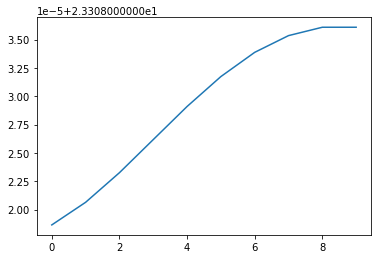

In [93]:
Storage_Temperature=np.empty((n_nodes, 0)).tolist()
time=482
for i in range(time):
    for j in range(n_nodes):
        if i%1==0:
            Storage_Temperature[j].append(storage.nodes_Temperature[j])
    storage.Mass_energy_balance(dt=dt,T_in=T_in,M_in=m_in,M_out=m_out,T_inf=T_inf)
plt.plot(storage.nodes_Temperature)

In [94]:
output_notebook()
colors = itertools.cycle(palette)    
graph = figure(title='IAM vs Incidence angle',plot_width=700, plot_height=500,     # Creates the base figure
                   tools='pan,box_zoom,hover,reset,wheel_zoom,save') #

for i, color in zip(range(n_nodes), colors):
    y = Storage_Temperature[i]
    x=np.arange(time)
    graph.line(x, y, legend_label=f"node {i}", color=color,line_width=2)
show(graph)

Loading BokehJS ...

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
plt.plot(t_60x60)
plt.plot(t_3600)

In [ ]:
y_true = t_60x60
y_pred = t_3600
rmse=np.sqrt(mean_squared_error(y_true, y_pred))
r2=r2_score(y_true, y_pred)

In [ ]:
print(rmse)
print(r2)